In [1]:
# Numeric computation
import numpy as np
import pandas as pd 
import seaborn as sns
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)

# Augmentation code
import keras_cv

# Plotting
import matplotlib.pyplot as plt

# Setting seeds (for reproducibility purposes)

In [2]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Loading dataset

In [3]:
file_path = "/kaggle/input/initial/clean_data.npz"


# Load initial dataset and extract images and labels
data = np.load(file_path)
images, labels = data['images'], data['labels']


# Inspect the content of the initial dataset (image size, label size...)
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Datatype images: {images.dtype}")
# print(images[0])

Images shape: (11959, 96, 96, 3)
Labels shape: (11959, 1)
Datatype images: float32


# Analysing the data and plotting some samples

The class distribution on the data set is: {0: 852, 1: 2181, 2: 1085, 3: 2026, 4: 849, 5: 993, 6: 2330, 7: 1643}


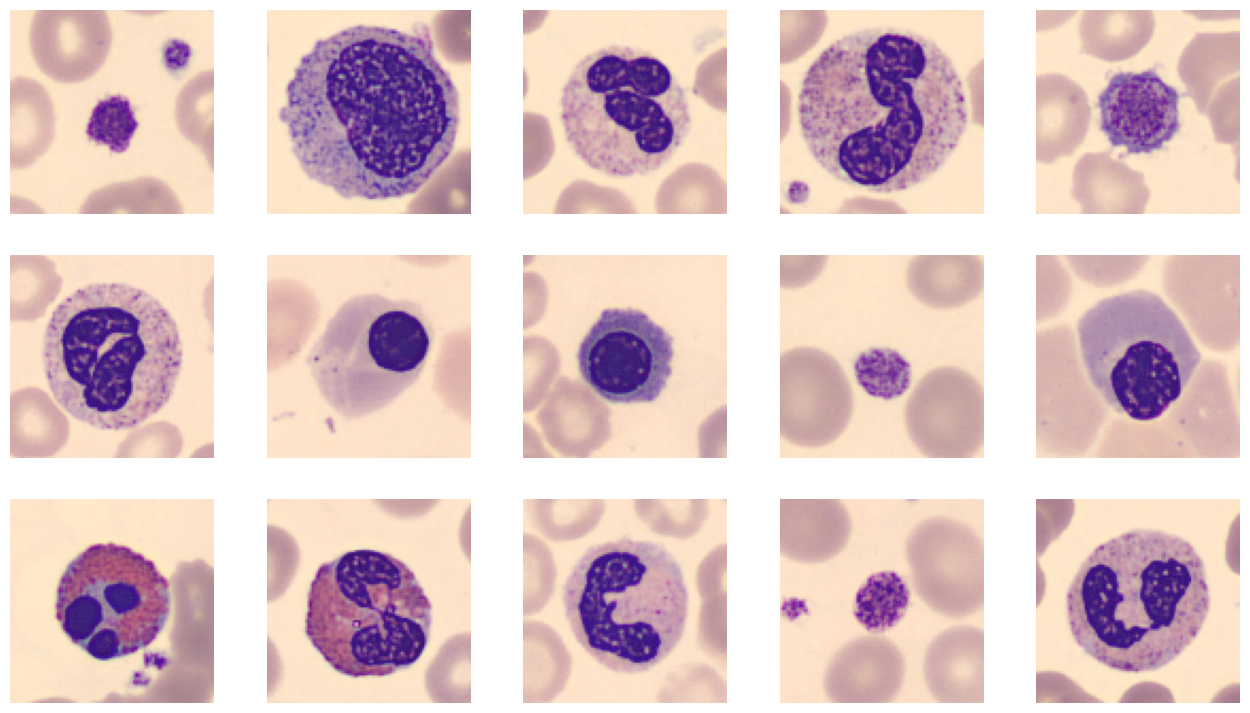

In [4]:
# Class labels
labels_dict = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet",
}

# Count number of instances of each class in the dataset
class_count = {}
for i in labels_dict:
    class_count[i] = np.unique(labels, return_counts=True)[1][i]
    
print(f"The class distribution on the data set is: {class_count}")

# Plot some examples
plot_img = images[:15]

plt.figure(figsize=(16,9))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(plot_img[i])
    plt.axis('off')

# Preprocessing steps

The images are RGB images of shape 96x96x3. The preprocessing steps on the data are:
- Convert labels into one-hot encoding
- Split into train, validation and test sets
Notice that data is automatically shuffled by the train_test_split function

In [5]:
# Tunable parameters
# 10% of input data to both test and validation sets
test_ratio = 0.05 
validation_ratio = 0.05 / 0.9 

# Convert labels to one-hot encoding
labels = to_categorical(labels, num_classes=8).astype('float32')

# Split data into (training & validation) and test sets
x_train_val, x_test, y_train_val, y_test = train_test_split(images, labels, random_state=seed, test_size=test_ratio, stratify=np.argmax(labels,axis=1))

# Further split train_val into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=seed, test_size=validation_ratio, stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (10729, 96, 96, 3), y_train shape: (10729, 8)
x_val shape: (632, 96, 96, 3), y_val shape: (632, 8)
x_test shape: (598, 96, 96, 3), y_test shape: (598, 8)


## Data augmentation pipeline (helper functions)
Data is augmented using different techniques, in particular a random pipeline, Cutmix, Fouriermix and Mixup

In [6]:
# Rescaling

def rescale_inputs(images, labels):
    images = images * 255.0  # Scale normalized inputs [0, 1] to [0, 255]
    return images, labels


def apply_mixup_cutmix(images, labels):

    mixup = keras_cv.layers.MixUp(alpha=0.2)
    cutmix = keras_cv.layers.CutMix(alpha=0.2)

    # Randomly choose between CutMix, MixUp, or no augmentation
    choice = tf.random.uniform([], minval=0, maxval=1, dtype=tf.int32)

    if choice == 0:
        augmented = mixup({"images": images, "labels": labels})
    else:
        augmented = cutmix({"images": images, "labels": labels})
    
    return augmented["images"], augmented["labels"]



geometric_pipeline = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip horizontally and vertically
    tf.keras.layers.RandomRotation(0.2),  # Rotate up to ±20% of 360°
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Translate up to 10%
])

# Random augmentations for images only
def geometric_pipeline_pretrain(images, labels):
    images = geometric_pipeline(images)
    return images, labels


    
colour_pipeline = tf.keras.Sequential([
    tf.keras.layers.RandomBrightness(factor=0.2, value_range=(0.0, 1.0)),  # Adjust brightness by ±20%
    tf.keras.layers.RandomContrast(factor=0.2),  # Adjust contrast by ±20%
    keras_cv.layers.RandomSaturation(factor=0.2),
    keras_cv.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
])

def colour_pipeline_pretrain(images, labels):
    images = colour_pipeline(images)
    return images, labels



mixed_pipeline = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip horizontally and vertically
    tf.keras.layers.RandomRotation(0.2),  # Rotate up to ±20% of 360°
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Translate up to 10%
    tf.keras.layers.RandomBrightness(factor=0.2, value_range=(0.0, 1.0)),  # Adjust brightness by ±20%
    tf.keras.layers.RandomContrast(factor=0.2),  # Adjust contrast by ±20%
])
    
def mixed_pipeline_pretrain(images, labels):
    images = mixed_pipeline(images)
    return images, labels



def create_augmented_dataset_pretrain(images, labels, batch_size=64):
    # Original dataset
    original_dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    # Augmented dataset with random pipeline
    aug_data_geometric = original_dataset.map(geometric_pipeline_pretrain, num_parallel_calls=tf.data.AUTOTUNE)
    aug_data_colour = original_dataset.map(colour_pipeline_pretrain, num_parallel_calls=tf.data.AUTOTUNE)
    aug_data_mixed = original_dataset.map(mixed_pipeline_pretrain, num_parallel_calls=tf.data.AUTOTUNE)

    # Augmented dataset with MixUp and CutMix (batch-wise augmentation)
    mixup_cutmix_dataset = (
        original_dataset.batch(batch_size)
        .map(apply_mixup_cutmix, num_parallel_calls=tf.data.AUTOTUNE)
        .unbatch()
    )

    # Combine all datasets: original + random augmented + MixUp/CutMix
    full_dataset = original_dataset.concatenate(aug_data_geometric).concatenate(aug_data_colour).concatenate(aug_data_mixed).concatenate(mixup_cutmix_dataset)

    # Shuffle, batch, and prefetch for efficiency
    full_dataset = full_dataset.shuffle(buffer_size=len(images))
    full_dataset = full_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE).repeat()

    return full_dataset





# AUGMENTED DATA FOR FINE TUNING (FEWER PIPELINES, MORE LIGHTWEIGHT TRANSFORMATIONS)
geometric_pipeline_ft = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip horizontally and vertically
    tf.keras.layers.RandomRotation(0.1),  # Rotate up to ±20% of 360°
    tf.keras.layers.RandomTranslation(height_factor=0.05, width_factor=0.05),  # Translate up to 10%
])

# Random augmentations for images only
def apply_geometric_pipeline_ft(images, labels):
    images = geometric_pipeline_ft(images)
    return images, labels


    
colour_pipeline_ft = tf.keras.Sequential([
    tf.keras.layers.RandomBrightness(factor=0.1, value_range=(0.0, 1.0)),  # Adjust brightness by ±20%
    tf.keras.layers.RandomContrast(factor=0.1),  # Adjust contrast by ±20%
    keras_cv.layers.RandomSaturation(factor=0.1),
    keras_cv.layers.RandomTranslation(height_factor=0.05, width_factor=0.05),
])

def apply_colour_pipeline_ft(images, labels):
    images = colour_pipeline_ft(images)
    return images, labels



mixed_pipeline_ft = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip horizontally and vertically
    tf.keras.layers.RandomRotation(0.1),  # Rotate up to ±20% of 360°
    tf.keras.layers.RandomTranslation(height_factor=0.05, width_factor=0.05),  # Translate up to 10%
    tf.keras.layers.RandomBrightness(factor=0.1, value_range=(0.0, 1.0)),  # Adjust brightness by ±20%
    tf.keras.layers.RandomContrast(factor=0.1),  # Adjust contrast by ±20%
])
    
def apply_mixed_pipeline_ft(images, labels):
    images = mixed_pipeline_ft(images)
    return images, labels



def create_augmented_dataset_finetuning(images, labels, batch_size=64):
    # Original dataset
    original_dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    # Augmented dataset with random pipeline
    aug_data_geometric = original_dataset.map(apply_geometric_pipeline_ft, num_parallel_calls=tf.data.AUTOTUNE)
    aug_data_colour = original_dataset.map(apply_colour_pipeline_ft, num_parallel_calls=tf.data.AUTOTUNE)
    aug_data_mixed = original_dataset.map(apply_mixed_pipeline_ft, num_parallel_calls=tf.data.AUTOTUNE)

    # Combine all datasets: original + random augmented + MixUp/CutMix
    full_dataset = original_dataset.concatenate(aug_data_geometric).concatenate(aug_data_colour).concatenate(aug_data_mixed)

    # Shuffle, batch, and prefetch for efficiency
    full_dataset = full_dataset.shuffle(buffer_size=len(images))
    full_dataset = full_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE).repeat()

    return full_dataset

# Training parameters

In [7]:
# Training parameters

# Input shape for the model
input_shape = x_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

# Number of training epochs
epochs = 28

# Batch size for training
batch_size = 64 

# Learning rate: step size for updating the model's weights
learning_rate = 0.001 

# Define the patience value for early stopping
patience = 7

# Weighted loss function to compensate for underrepresentation of some classes
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(np.argmax(y_train, axis=1)), 
    y=np.argmax(y_train, axis=1)  # Convert one-hot labels to class indices
)
# Convert class weights to a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}


# Print the defined parameters
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rate:", learning_rate)
print("Class Weights:", class_weights_dict)

Input Shape: (96, 96, 3)
Output Shape: 8
Epochs: 28
Batch Size: 64
Learning Rate: 0.001
Class Weights: {0: 1.755399214659686, 1: 0.685296371997956, 2: 1.3769250513347022, 3: 0.7376925192519251, 4: 1.76000656167979, 5: 1.5068820224719102, 6: 0.6416866028708134, 7: 0.9098541383989145}


# Build the model

In [8]:
# Backbone
model_large = tfk.applications.ConvNeXtXLarge(
    include_top=False, #can change this
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling="avg", #can change this
    classes=8,
    classifier_activation="softmax"    
)
tfk.utils.plot_model(model_large, show_shapes=True)

model_large.trainable = False #Freeze the weights of the CNN
tf.random.set_seed(seed)

# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
], name='Augmentation')

x = augmentation(inputs)

# Connect ConvNeXtXLarge to the input
x = model_large(x)

###################################################################################################
# Adding additional layers here
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.5)(x)

x = tfkl.Dense(512, activation='relu', name='dense1')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.5)(x)

x = tfkl.Dense(256, activation='relu', name='dense2')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.5)(x)

x = tfkl.Dense(128, activation='relu', name='dense3')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.5)(x)
###################################################################################################
# Add a Dense layer with 8 units and softmax activation as the classifier
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate), metrics=['accuracy'])

# Display a summary of the model architecture
# model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
# tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=patience,            
    verbose=1,              
    restore_best_weights=True  
)

reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=patience, min_lr=1e-6, verbose=1
)

# Store the callback in a list
callbacks = [reduce_lr, early_stopping]

1393257616/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


# Fine tuning
The process is going to be very similar to the previous one, but with a simplified augmented pipeline and no splitting of the data.

In [9]:
# Load previous best model
model = tf.keras.models.load_model("/kaggle/input/conv/keras/default/1/best_model.keras")

# Set the ConvNeXtXLarge model layers as trainable
model.get_layer('convnext_xlarge').trainable = True

# Set all ConvNeXtXLarge layers as non-trainable
for layer in model.get_layer('convnext_xlarge').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(model.get_layer('convnext_xlarge').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

# Set the number of layers to freeze at the beginning of the network
N = 124


# Set the first N layers as non-trainable
for i, layer in enumerate(model.get_layer('convnext_xlarge').layers[:N]):
    layer.trainable = False

# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])



train_dataset = create_augmented_dataset_finetuning(images, labels)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

augmentation_steps_finetuning = 3
steps_per_epoch = (len(x_train) * (augmentation_steps_finetuning + 1)) // batch_size

# Rescaling step needed for ConvNextXLarge
train_dataset = train_dataset.map(rescale_inputs, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(rescale_inputs, num_parallel_calls=tf.data.AUTOTUNE)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)],
    class_weight=class_weights_dict,
).history



model_filename = 'model_large.keras'

model.save(model_filename)

3 convnext_xlarge_stage_0_block_0_depthwise_conv Conv2D True
10 convnext_xlarge_stage_0_block_1_depthwise_conv Conv2D True
17 convnext_xlarge_stage_0_block_2_depthwise_conv Conv2D True
25 convnext_xlarge_stage_1_block_0_depthwise_conv Conv2D True
32 convnext_xlarge_stage_1_block_1_depthwise_conv Conv2D True
39 convnext_xlarge_stage_1_block_2_depthwise_conv Conv2D True
47 convnext_xlarge_stage_2_block_0_depthwise_conv Conv2D True
54 convnext_xlarge_stage_2_block_1_depthwise_conv Conv2D True
61 convnext_xlarge_stage_2_block_2_depthwise_conv Conv2D True
68 convnext_xlarge_stage_2_block_3_depthwise_conv Conv2D True
75 convnext_xlarge_stage_2_block_4_depthwise_conv Conv2D True
82 convnext_xlarge_stage_2_block_5_depthwise_conv Conv2D True
89 convnext_xlarge_stage_2_block_6_depthwise_conv Conv2D True
96 convnext_xlarge_stage_2_block_7_depthwise_conv Conv2D True
103 convnext_xlarge_stage_2_block_8_depthwise_conv Conv2D True
110 convnext_xlarge_stage_2_block_9_depthwise_conv Conv2D True
117 con

I0000 00:00:1732444167.150248      68 service.cc:145] XLA service 0x7fea05c58410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732444167.150325      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732444167.539673      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


670/670 ━━━━━━━━━━━━━━━━━━━━ 1531s 2s/step - accuracy: 0.9409 - loss: 0.1882 - val_accuracy: 0.9794 - val_loss: 0.0609
Epoch 2/28
670/670 ━━━━━━━━━━━━━━━━━━━━ 1498s 2s/step - accuracy: 0.9544 - loss: 0.1395 - val_accuracy: 0.9858 - val_loss: 0.0505
Epoch 3/28
670/670 ━━━━━━━━━━━━━━━━━━━━ 1492s 2s/step - accuracy: 0.9575 - loss: 0.1283 - val_accuracy: 0.9889 - val_loss: 0.0405
Epoch 4/28
670/670 ━━━━━━━━━━━━━━━━━━━━ 1488s 2s/step - accuracy: 0.9629 - loss: 0.1143 - val_accuracy: 0.9842 - val_loss: 0.0395
Epoch 5/28
670/670 ━━━━━━━━━━━━━━━━━━━━ 1489s 2s/step - accuracy: 0.9619 - loss: 0.1147 - val_accuracy: 0.9873 - val_loss: 0.0371
Epoch 6/28
670/670 ━━━━━━━━━━━━━━━━━━━━ 1490s 2s/step - accuracy: 0.9605 - loss: 0.1220 - val_accuracy: 0.9873 - val_loss: 0.0338
Epoch 7/28
670/670 ━━━━━━━━━━━━━━━━━━━━ 1491s 2s/step - accuracy: 0.9627 - loss: 0.1121 - val_accuracy: 0.9921 - val_loss: 0.0306
Epoch 8/28
670/670 ━━━━━━━━━━━━━━━━━━━━ 1486s 2s/step - accuracy: 0.9634 - loss: 0.1110 - val_accurac

598
Accuracy score over the test set: 0.9849
Precision score over the test set: 0.9855
Recall score over the test set: 0.9849
F1 score over the test set: 0.985


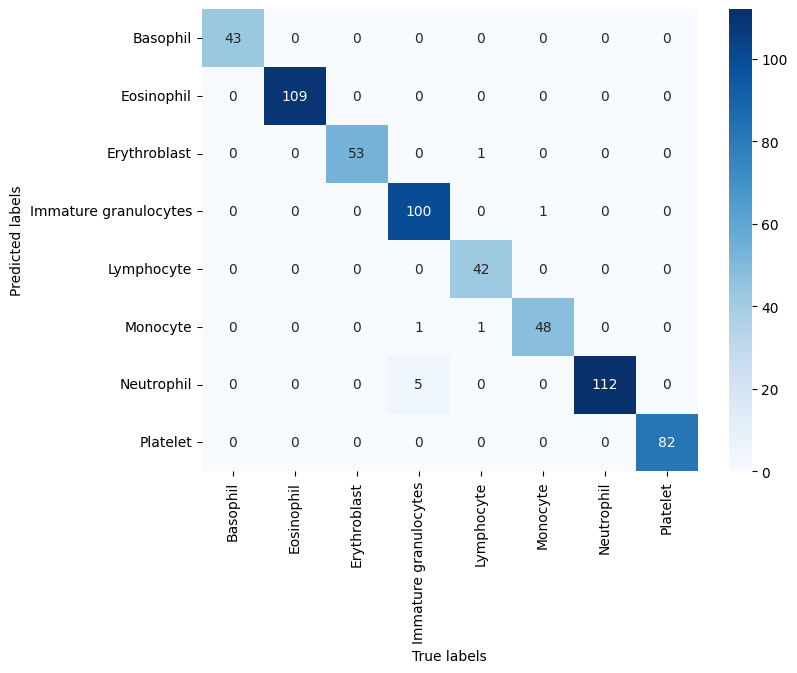

In [10]:
# Predict class probabilities and get predicted classes

test_predictions = model.predict(x_test*255, verbose=0)
print(len(test_predictions))
test_predictions = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f"Accuracy score over the test set: {round(test_accuracy, 4)}")

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average="weighted")
print(f"Precision score over the test set: {round(test_precision, 4)}")

# Calculate and display test set recall
test_recall = recall_score(test_gt, test_predictions, average="weighted")
print(f"Recall score over the test set: {round(test_recall, 4)}")

# Calculate and display test set F1 score
test_f1 = f1_score(test_gt, test_predictions, average="weighted")
print(f"F1 score over the test set: {round(test_f1, 4)}")

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=labels,
    fmt="",
    xticklabels=list(labels_dict.values()),
    yticklabels=list(labels_dict.values()),
    cmap="Blues",
)

plt.xlabel("True labels")
plt.ylabel("Predicted labels")
plt.show()


# Delete the model to free up resources
del model